In [136]:
import matplotlib
from matplotlib.gridspec import GridSpec
import matplotlib.ticker as mticker
import matplotlib.pyplot as plt
import cmocean
import numpy as np
import cartopy.crs as ccrs
import xarray as xr
import glob
import pandas as pd

In [100]:
recon_geo='Marcilly2021'
paths=sorted(glob.glob('../datapublication_MesoOrb-Newark/simulations/???Ma_*{}'.format(recon_geo)))

locs_df=pd.read_pickle('./files_misc_climberx-work/gplates_reconstruction/localities_gplates_Marcilly2021_df.pkl'.format(recon_geo))
loc_df=pd.DataFrame(data=locs_df.loc['Newark']['latlons_recon'],columns=['lat','lon'],index=locs_df.loc['Newark']['ages_recon'])
loc_df.index.name='age'
#loc_df

lons_1degr=np.arange(-180+0.5,180-0.5+1,1)
lats_1degr=np.arange(90-0.5,-90+0.5-1,-1)
lons_1degr_2D,lats_1degr_2D=np.meshgrid(lons_1degr,lats_1degr)

r_earth=6371 # Earth's radius in km

runs=[]
for path in paths:
    run=path[path.rfind('/')+1:] 
    runs+=[run]

runs_df=pd.DataFrame([], columns=['age','pCO2','coords_loc','path'], index=runs)

for run_idx,run in enumerate(runs_df.index):

    idx_Ma=run.find('Ma')
    age=int(run[idx_Ma-3:idx_Ma])

    idx_ppm=run.find('ppm')
    pCO2=int(run[idx_ppm-4:idx_ppm])      

#     run=path[path.rfind('/')+1:] 
       
    coords_loc=list(np.around(loc_df.loc[age],2))
    
#     lat=loc_df.lat.values[0]
#     lon=loc_df.lon.values[0]

#     dist=r_earth*np.arccos(np.sin(lat*np.pi/180)*np.sin(lats_1degr_2D*np.pi/180)+np.cos(lat*np.pi/180)*np.cos(lats_1degr_2D*np.pi/180)*np.cos((lon-lons_1degr_2D)*np.pi/180)) 
#     radius_AreaOfInterest=600. #km
#     region_mask=1*(dist>radius_AreaOfInterest) # 1e3 km
        
    runs_df.loc[run]=age,pCO2,coords_loc,paths[run_idx]
    

#runs_df


/home/janlandw/.conda/envs/py_jan/lib/python3.9/site-packages/pandas/core/internals/blocks.py:993: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr_value = np.array(value)


In [96]:
'{:03}'.format(age)

'000'

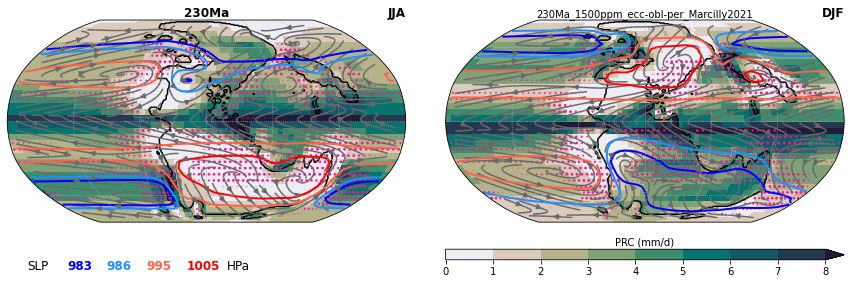

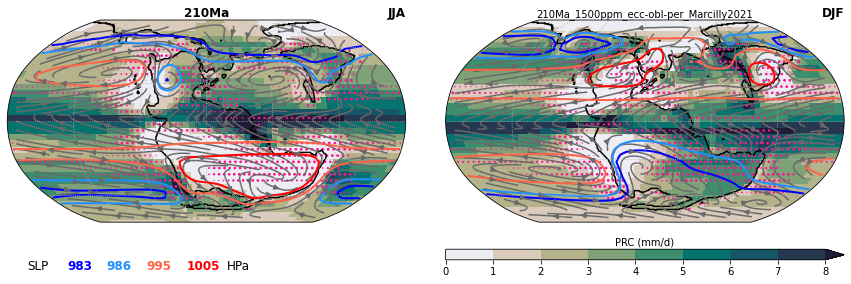

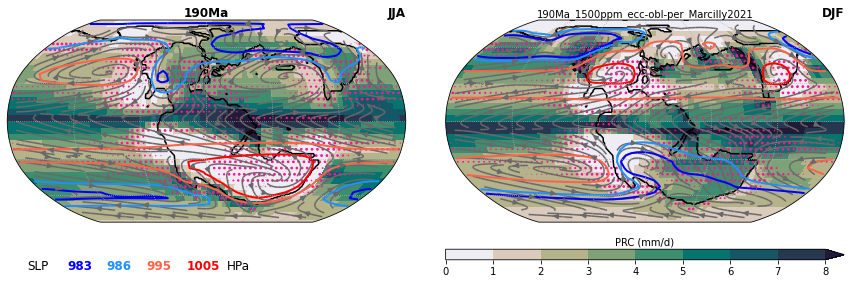

In [143]:
ages_plot=[230,210,190]

def func_condi_monsoon(prc_wet_NHSH,prc_dry_NHSH,prc_ann,temp_min):
    prc_wetdry_NHSH=prc_wet_NHSH-prc_dry_NHSH
    condi_monsoon_1=(prc_wetdry_NHSH>=2)
    condi_monsoon_2=(((prc_wet_NHSH*5*30)/(prc_ann*12*30))>=0.55)
    condi_monsoon_T=(temp_min>0)
    condi_monsoon=(condi_monsoon_1 & condi_monsoon_2 & condi_monsoon_T)   
    return condi_monsoon

for age_idx,age in enumerate(ages_plot): 

    age_str='{:03}'.format(age)
    run='{}Ma_1500ppm_ecc-obl-per_Marcilly2021'.format(age_str)

    [path,pCO2]=runs_df.loc[run, ['path','pCO2']]#[0]    
    
    fig,axs=plt.subplots(2,2,subplot_kw={'projection': ccrs.Robinson()},facecolor='w',figsize=(15,4.5),gridspec_kw={'height_ratios': [1,0.05]})
    gs = GridSpec(2, 2, figure=fig,width_ratios=[1,1],height_ratios=[1,0.05])
    for ii in range(2):
        axs[-1,ii].remove()
        axs[-1,ii]=fig.add_subplot(gs[-1,ii])
    ax_text = axs[-1,0] 
    ax_text.axis('off')
    ax_cbar = axs[-1,-1] 

    ds=xr.open_dataset('../datapublication_MesoOrb-Newark/simulations/{}'.format(run)+'/atm_reduced.nc')

    ds_sel=ds[['prc','us','vs','slp','t2a']].isel(time=slice(49,249+1,1))#.mean(dim=['time']) 
    ds_sel_ref=ds_sel.mean(dim=['time']) 
    
    prc=ds_sel.prc.isel(mon=slice(0,11+1,1))
    prc_pad=prc.pad(mon=2,mode='wrap')
    prc_roll=prc_pad.rolling(mon=5,center=True).mean()
    
    prc_roll_NH=prc_roll.where(prc_roll.lat>0)
    prc_roll_SH=prc_roll.where(prc_roll.lat<0)
    prc_wet_NH=prc_roll_NH.max(dim='mon').fillna(0)
    prc_wet_SH=prc_roll_SH.max(dim='mon').fillna(0)
    prc_dry_NH=prc_roll_NH.min(dim='mon').fillna(0)
    prc_dry_SH=prc_roll_SH.min(dim='mon').fillna(0)
    prc_wet_NHSH=prc_wet_NH+prc_wet_SH
    prc_dry_NHSH=prc_dry_NH+prc_dry_SH
    prc_wetdry_NHSH=prc_wet_NHSH-prc_dry_NHSH
    prc_ann=prc.mean(dim='mon')
    temp_min=ds_sel.t2a.isel(mon=slice(0,11+1,1)).min(dim='mon')-273.15
    monsoon_intensity=(prc_wet_NHSH-prc_dry_NHSH)/prc_ann    
    
    prc_ref=prc.mean(dim=['time']) 
    prc_ref_wet_NHSH=prc_wet_NHSH.mean(dim=['time']) 
    prc_ref_dry_NHSH=prc_dry_NHSH.mean(dim=['time'])
    prc_ref_ann=ds_sel_ref.prc.isel(mon=-1)
    temp_ref_min=ds_sel_ref.t2a.isel(mon=slice(0,11+1,1)).min(dim='mon')-273.15    
    
    condi_monsoon_times=func_condi_monsoon(prc_wet_NHSH,prc_dry_NHSH,prc_ann,temp_min)
    condi_monsoon_anytime=condi_monsoon_times.any(dim='time')
    condi_monsoon_ref=func_condi_monsoon(prc_ref_wet_NHSH,prc_ref_dry_NHSH,prc_ref_ann,temp_ref_min)
    
    ds_sel_JJA=ds_sel_ref.isel(mon=[5,6,7]).mean(dim=['mon'])
    ds_sel_DJF=ds_sel_ref.isel(mon=[11,0,1]).mean(dim=['mon'])

    ds_geo=xr.open_dataset(path+'/geo_hires.nc')
    lo_mask=(ds_geo.z_bed.isel(time=-1)>0)
    
    for aa in axs[0,:]:
        lo_mask.plot.contour(ax=aa,transform=ccrs.PlateCarree(),levels=[0.5],colors='k');
        
    cscale=8   
    p_cbar=ds_sel_JJA['prc'].plot(ax=axs[0,0],transform=ccrs.PlateCarree(),cmap=cmocean.cm.rain,vmin=0,vmax=cscale,levels=int(cscale+1),add_colorbar=False) 
    ds_sel_DJF['prc'].plot(ax=axs[0,1],transform=ccrs.PlateCarree(),cmap=cmocean.cm.rain,vmin=0,vmax=cscale,levels=int(cscale+1),add_colorbar=False) 
    gl0=axs[0,0].gridlines(linestyle=':')     
    gl1=axs[0,1].gridlines(linestyle=':') 
    
    
    var=(1*(condi_monsoon_times)).sum(dim='time')
    var=3*var/var.max()
    X,Y=np.meshgrid(var.lon,var.lat)
    axs[0,0].scatter(X,Y,s=var.data,c='deeppink',transform=ccrs.PlateCarree())
    axs[0,1].scatter(X,Y,s=var.data,c='deeppink',transform=ccrs.PlateCarree())
    
    opt_quiver='wind' 
    qvmscale=8e3
    
    qvwscale=250 #8e3
    ds_sel_JJA.plot.streamplot(x='lon',y='lat',u='us',v='vs',ax=axs[0,0],transform=ccrs.PlateCarree(),color='dimgrey',density=1.5)
    ds_sel_DJF.plot.streamplot(x='lon',y='lat',u='us',v='vs',ax=axs[0,1],transform=ccrs.PlateCarree(),color='dimgrey',density=1.5)

    axs[0,0].text(0.5,1,'{}Ma'.format(age),transform=axs[0,0].transAxes,va='bottom',ha='center',fontweight='bold',fontsize=12)
    axs[0,0].text(1,1,'JJA',transform=axs[0,0].transAxes,va='bottom',ha='right',fontweight='bold',fontsize=12)
    axs[0,1].text(1,1,'DJF',transform=axs[0,1].transAxes,va='bottom',ha='right',fontweight='bold',fontsize=12)
    axs[0,1].text(0.5,1,'{}'.format(run),transform=axs[0,1].transAxes,va='bottom',ha='center',fontsize=10)
    
    slp_levs=[983e2,986e2,995e2,1005e2]
    slp_cols=['b','dodgerblue','tomato','r']
    ds_sel_JJA.slp.plot.contour(ax=axs[0,0],levels=slp_levs,colors=slp_cols,transform=ccrs.PlateCarree(),linewidths=2)
    ds_sel_DJF.slp.plot.contour(ax=axs[0,1],levels=slp_levs,colors=slp_cols,transform=ccrs.PlateCarree(),linewidths=2)

    for ll in range(len(slp_levs)):
        ax_text.text(0.15+ll*0.1,0,'{}'.format(int(slp_levs[ll]/100)),color=slp_cols[ll],va='top',ha='left',fontsize=12,fontweight='bold')
    ax_text.text(0.15+0.1*len(slp_levs),0,'HPa'.format(slp_levs[ll]),va='top',ha='left',fontsize=12)
    ax_text.text(0.05,0,'SLP',va='top',ha='left',fontsize=12)

    cbar=plt.colorbar(p_cbar,cax=ax_cbar,orientation='horizontal')
    ax_cbar.set_xlabel('PRC (mm/d)',fontsize=10)
    ax_cbar.xaxis.set_label_position('top')    

    plt.subplots_adjust(wspace=0.1)
    # fig.savefig('./Plots_MesoOrb-Newark/MesoOrb-Newark_rev1_maps_monsoon+SLP+wind_{}to{}Ma_Cao201718.pdf'.format(ages_plot[0],ages_plot[-1]),bbox_inches='tight', dpi=900)#